<a href="https://colab.research.google.com/github/keiiigo/RecursosOpenSource/blob/main/PyVRPRestrictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyvrp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
from pyvrp import Model
import math
import matplotlib.pyplot as plt
from pyvrp.plotting import plot_coordinates
from pyvrp.stop import MaxRuntime
from pyvrp.plotting import plot_solution
from pyvrp.stop import MaxRuntime
import folium
import random
import requests
from pyvrp import SolveParams, PenaltyParams

In [14]:
GRAPH_HOPPER_URL = "http://localhost:8989/route"
SCALING_FACTOR = 1000000

df = pd.read_csv('lkmcor.csv')

df['Latitude'] = (df['Latitude'] * SCALING_FACTOR).round().astype(int)
df['Longitude'] = (df['Longitude'] * SCALING_FACTOR).round().astype(int)
df['Demand'] = df['Demand'].astype(int)

COORDS = df[['Latitude', 'Longitude']].values
DEMANDS = df['Demand'].values
NAMES = df['Customer Name'].values

In [15]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

In [22]:
TIME_WINDOWS = [
    (df.loc[0, 'Time Window Early'] * 60 * 60, df.loc[0, 'Time Window Late'] * 60 * 60),
    *[(df.loc[idx, 'Time Window Early'] * 60 * 60, df.loc[idx, 'Time Window Late'] * 60 * 60) for idx in range(1, len(df))]
]

duration_matrix_df = pd.read_csv('duration_matrix.csv', index_col=0)

m = Model()
m.add_vehicle_type(
    num_available=11,
    capacity=1500,
    max_duration=6 * 60 * 60,
    tw_early=TIME_WINDOWS[0][0],
    tw_late=TIME_WINDOWS[0][1],
)

clients = [
    m.add_client(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        delivery=[DEMANDS[idx]],
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
        name=NAMES[idx]
    )
    for idx in range(1, len(COORDS))
]

depot = m.add_depot(x=COORDS[0][0], y=COORDS[0][1])

locations = [depot] + clients
location_mapping = {name: location for name, location in zip(NAMES, locations)}

duration_matrix_df.index = duration_matrix_df.index.str.strip().str.lower()
duration_matrix_df.columns = duration_matrix_df.columns.str.strip().str.lower()
location_mapping = {name.strip().lower(): location for name, location in location_mapping.items()}

assert set(duration_matrix_df.index) == set(duration_matrix_df.columns) == set(location_mapping.keys()), \
    "Mismatch between duration matrix and client/depot names"


for frm_name, frm in location_mapping.items():
    for to_name, to in location_mapping.items():
        if frm_name != to_name:
            lat1, lon1 = frm.x, frm.y
            lat2, lon2 = to.x, to.y
            distance = haversine(lat1, lon1, lat2, lon2)
            travel_duration = duration_matrix_df.loc[frm_name, to_name]
            m.add_edge(frm, to, distance=distance, duration=travel_duration)

In [23]:
penalty_params = PenaltyParams(
    repair_booster=20,
    solutions_between_updates=30,
    penalty_increase=1.5,
    penalty_decrease=0.1,
    target_feasible=1
)

solve_params = SolveParams(
    penalty=penalty_params
)

solution = m.solve(
    stop=MaxRuntime(30),
    display=True,
    params=solve_params,
)

PyVRP v0.10.1

Solving an instance with:
    1 depot
    94 clients
    11 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      3s |  37   229968   220314 |  40  6225880   231300
H    1000      6s |  42   225045   220129 |  55  4592525   226143
     1500      8s |  49   225817   220129 |  61  4164166   227030
H    2000     11s |  57   228329   216194 |  62  4101057   227030
H    2500     15s |  63   225092   216132 |  29  7729683   227030
     3000     17s |  29   219004   216132 |  37 13368019   227030
     3500     19s |  37   222827   216132 |  37 13368019   227030
     4000     21s |  45   221710   216132 |  38 13023093   227030
     4500     23s |  53   221518   216132 |  38 13023093   227030
     5000     27s |  61   223933   216132 |  38 13023093   227030
H    5500     29s |  28   222882   216063 |  38 13023093   227030

Search terminated in 30.00s after 5787 iterat

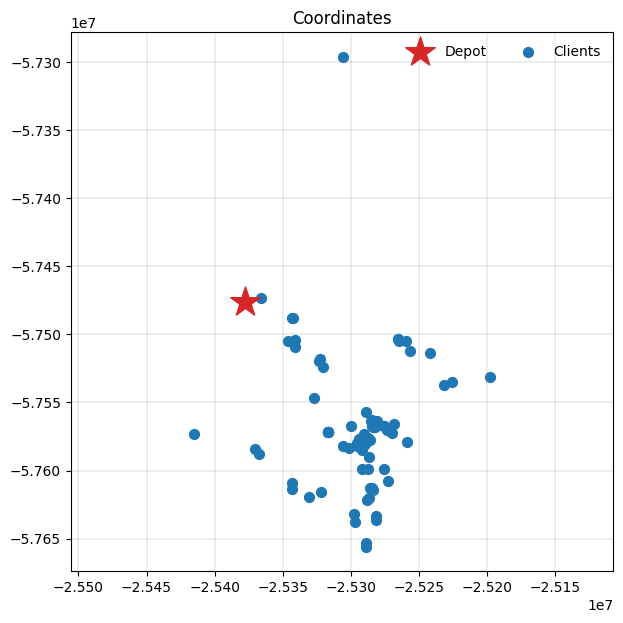

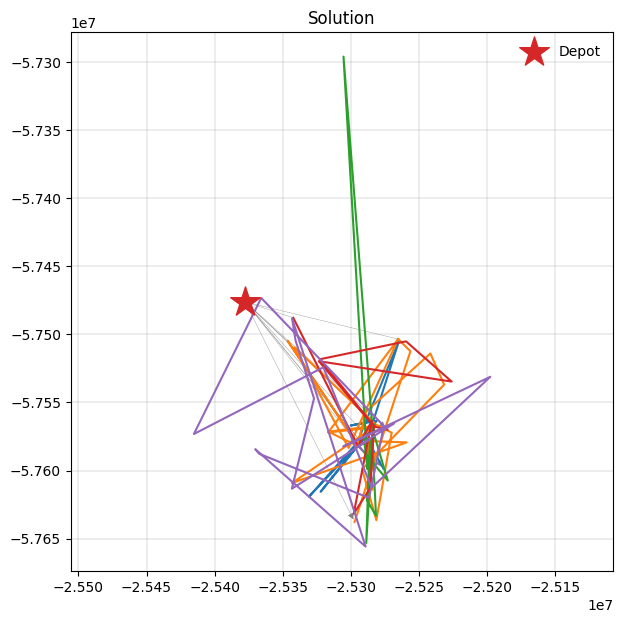

In [24]:
res = solution

_, ax = plt.subplots(figsize=(7, 7))
plot_coordinates(m.data(), ax=ax)

_, ax = plt.subplots(figsize=(7, 7))
plot_solution(res.best, m.data(), ax=ax)

In [ ]:
#Para Agregar La Visualizacion Folium y GraphHopper se necesita una conexion al servidor local de GraphHopper